# **Damped Oscillator Anomaly Detection with LSTM Autoencoder**

In [ ]:
"""IMPORTS & SETUP"""
import random, warnings, sys, importlib
warnings.filterwarnings("ignore")
sys.path.append('../utils')

# Utilities files
import simulation, preprocessing, training, evaluation, plots, thresholding, models
importlib.reload(simulation); importlib.reload(preprocessing); importlib.reload(training); importlib.reload(evaluation); importlib.reload(plots); importlib.reload(thresholding); importlib.reload(models)

from simulation import damped_oscillator, inject_spikes, inject_level_shifts, inject_freq_shift, inject_var_burst
from preprocessing import make_windows, scale, save_datasets, load_datasets, SeqDataset
from training import train_autoencoder, train_autoencoder_phys, plot_learning_curves
from evaluation import recon_errors, evaluate_on_test
from plots import plot_roc_pr_curves, plot_reconstruction_examples
from thresholding import threshold_percentile_on_train, threshold_youden, tune_threshold, eval_with
from models import LSTMAE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## **Simulation + Data preprocessing (windowing, splits, scaling)**

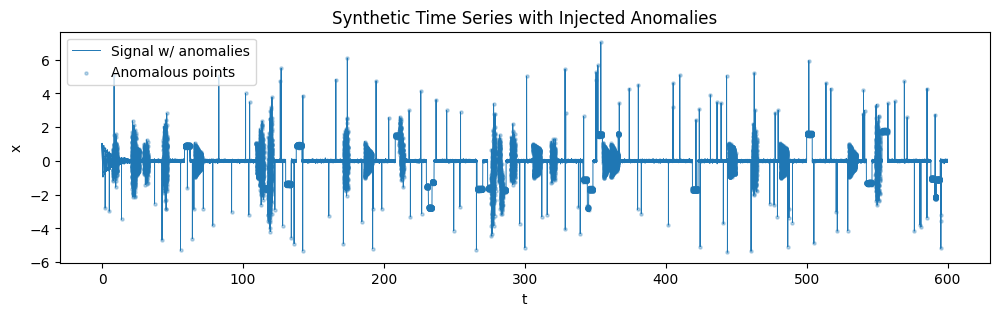

In [8]:
"""DAMPED OSCILLATOR DATA"""

"""
We simulate a damped oscillator with mild noise as NORMAL behavior.
We inject ANOMALIES:
- spikes
- level shifts (drift)
- frequency shifts
- variance bursts
We then window the signal for reconstruction-based anomaly detection.
"""

# Generate base normal signal
T = 60000
dt = 0.01
t, x_normal = damped_oscillator(T=T, dt=dt, zeta=0.03, omega0=2*np.pi*0.8, noise_std=0.04)

# Copy as base, then inject anomalies
x_mix = x_normal.copy()
x_mix, spike_idx = inject_spikes(x_mix, n_spikes=120, amp_range=(2.5, 5.5))
x_mix, shift_regions = inject_level_shifts(x_mix, n_shifts=20, width=400, amp_range=(0.8, 1.8))
x_mix, freq_regions = inject_freq_shift(x_mix, t, n_regions=10, width=500, scale_range=(0.5,1.7))
x_mix, var_regions  = inject_var_burst(x_mix, n_bursts=14, width=300, std_range=(0.4, 1.2))

# Create pointwise anomaly labels
point_labels = np.zeros_like(x_mix, dtype=int)
point_labels[spike_idx] = 1
for a,b in shift_regions + freq_regions + var_regions:
    point_labels[a:b] = 1

# Visual sanity check
plt.figure(figsize=(12,3))
plt.plot(t, x_mix, lw=0.7, label="Signal w/ anomalies")
plt.scatter(t[point_labels==1], x_mix[point_labels==1], s=5, alpha=0.3, label="Anomalous points")
plt.title("Synthetic Time Series with Injected Anomalies")
plt.xlabel("t"); plt.ylabel("x"); plt.legend(); plt.show()

In [9]:
"""WINDOWING + SPLITS"""

"""
We create overlapping windows. Each window gets label=1 if any point in the window is anomalous
(or use a proportion threshold). We'll use 'any' to be conservative.
"""

WIN = 128
STRIDE = 32
REQUIRE_RATIO = 0.05  # mark window anomalous if >=5% anomalous points inside
X_all, y_all = make_windows(x_mix, point_labels, win=WIN, stride=STRIDE, require_ratio=REQUIRE_RATIO)

print("Windows:", X_all.shape, "Labels:", y_all.shape, "Anomaly rate:", y_all.mean())

# Split into train (only normal), val (mix), test (mix)
# First create indices for normal/anomalous windows
idx_normal = np.where(y_all==0)[0]
idx_anom   = np.where(y_all==1)[0]

# training uses ONLY normal windows
train_normal_idx, hold_normal_idx = train_test_split(idx_normal, test_size=0.4, random_state=SEED, shuffle=True)
val_normal_idx, test_normal_idx   = train_test_split(hold_normal_idx, test_size=0.5, random_state=SEED, shuffle=True)

# choose anomalies for val/test (split roughly 50-50)
val_anom_idx, test_anom_idx = train_test_split(idx_anom, test_size=0.5, random_state=SEED, shuffle=True)

X_train = X_all[train_normal_idx]               # normal only
y_train = y_all[train_normal_idx]

X_val   = np.concatenate([X_all[val_normal_idx], X_all[val_anom_idx]], axis=0)
y_val   = np.concatenate([y_all[val_normal_idx], y_all[val_anom_idx]], axis=0)

X_test  = np.concatenate([X_all[test_normal_idx], X_all[test_anom_idx]], axis=0)
y_test  = np.concatenate([y_all[test_normal_idx], y_all[test_anom_idx]], axis=0)

# Shuffle val/test for randomness
val_perm = np.random.permutation(len(X_val))
test_perm= np.random.permutation(len(X_test))
X_val, y_val = X_val[val_perm], y_val[val_perm]
X_test, y_test = X_test[test_perm], y_test[test_perm]

print("Train (normal):", X_train.shape, y_train.mean())
print("Val (mix):", X_val.shape, y_val.mean())
print("Test (mix):", X_test.shape, y_test.mean())

Windows: (1872, 128, 1) Labels: (1872,) Anomaly rate: 0.31677350427350426
Train (normal): (767, 128, 1) 0.0
Val (mix): (552, 128, 1) 0.5362318840579711
Test (mix): (553, 128, 1) 0.5370705244122965


In [10]:
"""SCALING"""

"""
We scale per time step feature (here features=1). For sequence models we scale values globally
using StandardScaler fit on flattened training normals.
"""
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, 1)
scaler.fit(X_train_flat)

X_train_s = scale(X_train, scaler)
X_val_s   = scale(X_val, scaler)
X_test_s  = scale(X_test, scaler)

# Quick check
print("Scaled stats train:", X_train_s.mean(), X_train_s.std())

Scaled stats train: -1.736985175423974e-18 1.0


In [11]:
"""PYTORCH DATASETS / DATALOADERS"""

BATCH = 128

train_ds = SeqDataset(X_train_s)  # normal only
val_ds   = SeqDataset(X_val_s)
test_ds  = SeqDataset(X_test_s)

save_datasets(train_ds, val_ds, test_ds, data_dir="../data")

Datasets saved to '../data' directory.


## Load Dataset

In [12]:
train_ds, val_ds, test_ds = load_datasets(data_dir="../data")

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, drop_last=False)

Datasets loaded from '../data' directory.


## **LSTM Autoencoder - MSE Loss**


[TRAIN] LSTMAE
Epoch 001 | train 1.00025 | val 15.49786
Epoch 002 | train 1.00019 | val 15.50553
Epoch 003 | train 0.99993 | val 15.50037
Epoch 004 | train 0.99977 | val 15.49991
Epoch 005 | train 1.00003 | val 15.50145
Epoch 006 | train 1.00008 | val 15.49842
Epoch 007 | train 0.99991 | val 15.49696
Epoch 008 | train 0.99991 | val 15.49259
Epoch 009 | train 0.99946 | val 15.49593
Epoch 010 | train 0.99964 | val 15.48709
Epoch 011 | train 0.99941 | val 15.48278
Epoch 012 | train 0.99888 | val 15.48333
Epoch 013 | train 0.99891 | val 15.47176
Epoch 014 | train 0.99783 | val 15.44308
Epoch 015 | train 0.99511 | val 15.39135
Epoch 016 | train 0.99632 | val 15.44958
Epoch 017 | train 0.99627 | val 15.41859
Epoch 018 | train 0.99474 | val 15.37401
Epoch 019 | train 1.01292 | val 15.34935
Epoch 020 | train 0.99679 | val 15.45200
Epoch 021 | train 0.99749 | val 15.46926
Epoch 022 | train 0.99814 | val 15.46291
Epoch 023 | train 0.99828 | val 15.46173
Epoch 024 | train 0.99813 | val 15.46746


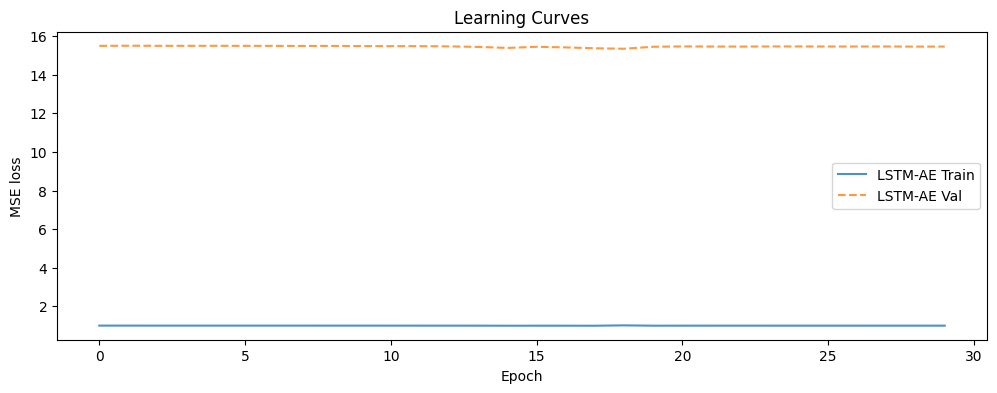

In [13]:
"""TRAIN THE MODELS"""

EPOCHS = 30

print(f"\n[TRAIN] LSTMAE")
lstm  = LSTMAE(in_dim=1, hidden=64, latent=32, num_layers=1, dropout=0.1)
lstm, hist_lstm  = train_autoencoder(lstm,  train_loader, val_loader, epochs=EPOCHS, lr=1e-3, weight_decay=1e-5)

print(f"\n[INFO] Learning Curves")
plot_learning_curves([hist_lstm], ["LSTM-AE"])

In [14]:
"""SCORING"""

err_val_lstm   = recon_errors(lstm,  X_val_s)

err_test_lstm  = recon_errors(lstm,  X_test_s)

In [15]:
"""THRESHOLD TUNING"""

"""
We choose threshold that maximizes F1 on validation set for each model.
We also store ROC/PR AUC for model selection.
"""

best_lstm, auroc_lstm_val, ap_lstm_val = tune_threshold(err_val_lstm,  y_val)

print("LSTM-AE  | thr={:.5f}  F1={:.3f}  P={:.3f}  R={:.3f} | AUROC={:.3f}  AUPRC={:.3f}".format(
    best_lstm["thr"], best_lstm["f1"], best_lstm["prec"], best_lstm["rec"], auroc_lstm_val, ap_lstm_val))


LSTM-AE  | thr=4.74940  F1=0.890  P=0.924  R=0.858 | AUROC=0.965  AUPRC=0.970


In [16]:
"""EVALUATION ON TEST"""

metrics_lstm, y_pred_lstm = evaluate_on_test(err_test_lstm,  y_test, best_lstm["thr"])

print("=== TEST METRICS ===")
for name, m in [("LSTM-AE", metrics_lstm)]:
    print(f"{name:8s} | AUROC={m['auroc']:.3f}  AUPRC={m['auprc']:.3f}  F1={m['f1']:.3f}  P={m['precision']:.3f}  R={m['recall']:.3f}")


=== TEST METRICS ===
LSTM-AE  | AUROC=0.973  AUPRC=0.977  F1=0.890  P=0.940  R=0.845


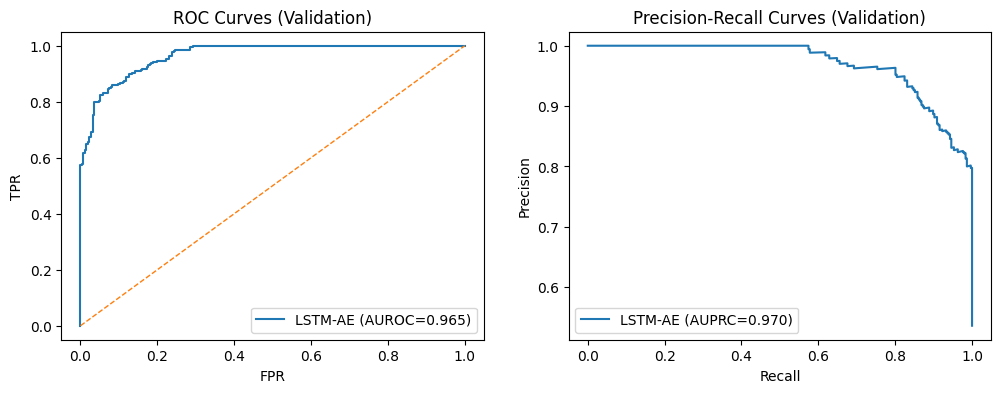

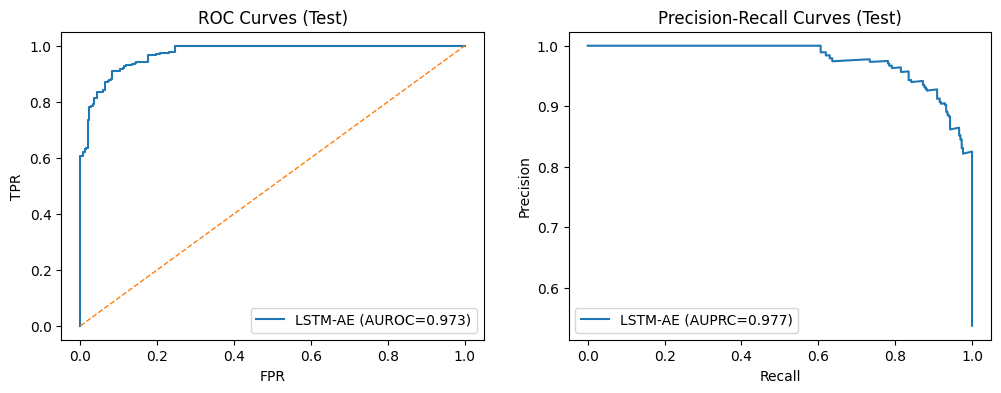

In [ ]:
"""ROC AND PR CURVES ON VALIDATION & TEST"""

plot_roc_pr_curves([err_val_lstm], y_val, ["LSTM-AE"], "(Validation)")
plot_roc_pr_curves([err_test_lstm], y_test, ["LSTM-AE"], "(Test)")

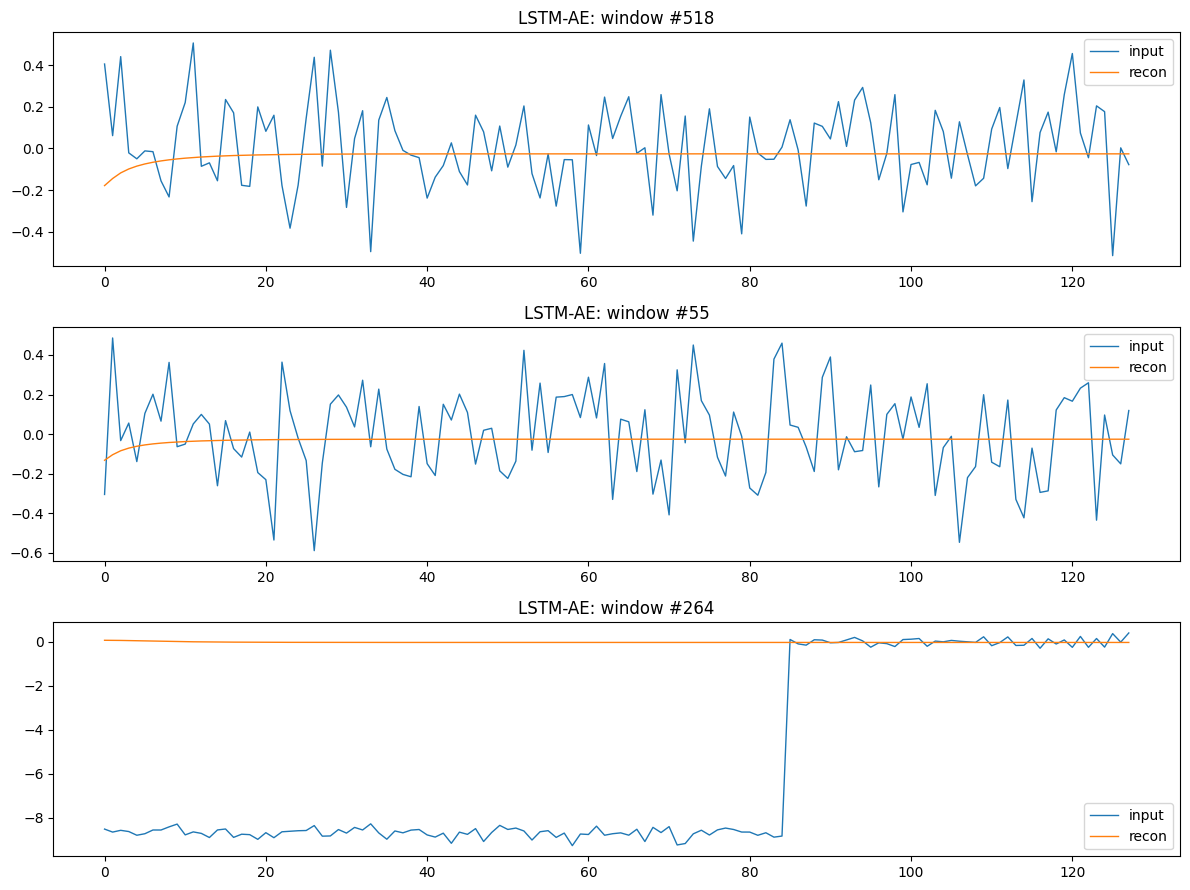

In [18]:
"""RECONSTRUCTION PLOTS"""

plot_reconstruction_examples(lstm,  X_test_s, n=3, title="LSTM-AE")

In [19]:
"""THRESHOLD TUNING VARIANTS"""

"""
We already used F1-maximization on validation. Two common alternatives:
- Percentile-based on train normal errors (e.g., 99th percentile) for a fixed false-positive budget
- Youden's J on ROC (maximizes TPR-FPR)
We'll show how you'd compute them, then evaluate on test.
"""

# Percentile (train normals)
thr_lstm_p = threshold_percentile_on_train(lstm, X_train_s, perc=99.5)

# Youden's J (validation)
thr_lstm_y = threshold_youden(err_val_lstm,  y_val)

print("\n=== Threshold strategies comparison (TEST) ===")
for name, err_t, thr_f1, thr_p, thr_y in [
    ("LSTM-AE", err_test_lstm,  best_lstm["thr"], thr_lstm_p, thr_lstm_y),
]:
    m_f1 = eval_with(thr_f1, err_t, y_test)
    m_p  = eval_with(thr_p,  err_t, y_test)
    m_y  = eval_with(thr_y,  err_t, y_test)
    print(f"{name:8s} | F1-tuned  F1={m_f1['f1']:.3f} P={m_f1['precision']:.3f} R={m_f1['recall']:.3f} AUROC={m_f1['auroc']:.3f}")
    print(f"          | Perc(99.5) F1={m_p['f1']:.3f} P={m_p['precision']:.3f} R={m_p['recall']:.3f} AUROC={m_p['auroc']:.3f}")
    print(f"          | YoudenJ    F1={m_y['f1']:.3f} P={m_y['precision']:.3f} R={m_y['recall']:.3f} AUROC={m_y['auroc']:.3f}")


=== Threshold strategies comparison (TEST) ===
LSTM-AE  | F1-tuned  F1=0.890 P=0.940 R=0.845 AUROC=0.973
          | Perc(99.5) F1=0.777 P=0.975 R=0.646 AUROC=0.973
          | YoudenJ    F1=0.890 P=0.940 R=0.845 AUROC=0.973


In [20]:
"""SUMMARY"""

rows = []
rows.append(["LSTM-AE", metrics_lstm["auroc"], metrics_lstm["auprc"], metrics_lstm["f1"], metrics_lstm["precision"], metrics_lstm["recall"]])

df_summary = pd.DataFrame(rows, columns=["Model","AUROC","AUPRC","F1","Precision","Recall"])
print("\n=== TEST SUMMARY (F1-tuned thresholds) ===")
print(df_summary.sort_values("F1", ascending=False).reset_index(drop=True))


=== TEST SUMMARY (F1-tuned thresholds) ===
     Model    AUROC     AUPRC        F1  Precision    Recall
0  LSTM-AE  0.97334  0.976814  0.890071   0.940075  0.845118


## **LSTM Autoencoder - Damped Oscillator Loss**


[TRAIN] LSTMAE
Epoch 001 | train 1.00017 | phys 3.35626 | val 15.50872
Epoch 002 | train 1.00021 | phys 1.10100 | val 15.50048
Epoch 003 | train 1.00018 | phys 0.21929 | val 15.50079
Epoch 004 | train 1.00024 | phys 0.05891 | val 15.50352
Epoch 005 | train 1.00003 | phys 0.14098 | val 15.50205
Epoch 006 | train 0.99990 | phys 0.14732 | val 15.50329
Epoch 007 | train 1.00019 | phys 0.11035 | val 15.50260
Epoch 008 | train 0.99983 | phys 0.11157 | val 15.50382
Epoch 009 | train 1.00048 | phys 0.09537 | val 15.50311
Epoch 010 | train 0.99962 | phys 0.08940 | val 15.50308
Epoch 011 | train 0.99950 | phys 0.09402 | val 15.50346
Epoch 012 | train 1.00007 | phys 0.08209 | val 15.50315
Epoch 013 | train 0.99994 | phys 0.08048 | val 15.50326
Epoch 014 | train 1.00014 | phys 0.07675 | val 15.50310
Epoch 015 | train 0.99989 | phys 0.07489 | val 15.50329
Epoch 016 | train 1.00007 | phys 0.07265 | val 15.50321
Epoch 017 | train 1.00003 | phys 0.06943 | val 15.50317
Epoch 018 | train 0.99995 | phys

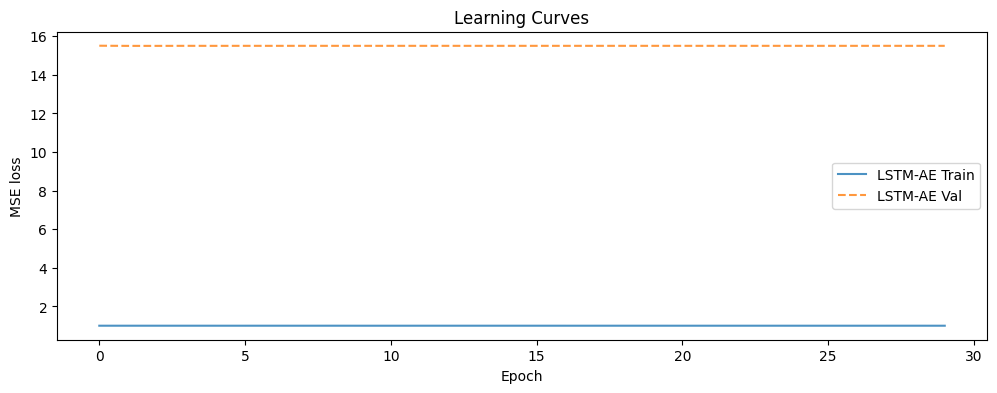

In [ ]:
"""TRAIN PI-LSTMAE"""

EPOCHS = 30

print(f"\n[TRAIN] LSTMAE")
lstm  = LSTMAE(in_dim=1, hidden=64, latent=32, num_layers=1, dropout=0.1)

lstm_phys, hist_lstm_phys = train_autoencoder_phys(lstm, train_loader, val_loader, epochs=EPOCHS, lr=1e-3, weight_decay=1e-5, lambda_phys=2.5)

print(f"\n[INFO] Learning Curves")
plot_learning_curves([hist_lstm_phys], ["LSTM-AE"])

In [22]:
"""SCORING"""

err_val_lstm_phys   = recon_errors(lstm_phys, X_val_s)

err_test_lstm_phys  = recon_errors(lstm_phys, X_test_s)

In [23]:
"""THRESHOLD TUNING"""

"""
We choose threshold that maximizes F1 on validation set for each model.
We also store ROC/PR AUC for model selection.
"""

best_lstm_phys, auroc_lstm_val_phys, ap_lstm_val_phys = tune_threshold(err_val_lstm_phys, y_val)

print("LSTM-AE  | thr={:.5f}  F1={:.3f}  P={:.3f}  R={:.3f} | AUROC={:.3f}  AUPRC={:.3f}".format(
    best_lstm_phys["thr"], best_lstm_phys["f1"], best_lstm_phys["prec"], best_lstm_phys["rec"], auroc_lstm_val_phys, ap_lstm_val_phys))


LSTM-AE  | thr=4.74711  F1=0.892  P=0.924  R=0.861 | AUROC=0.965  AUPRC=0.970


In [24]:
"""EVALUATION ON TEST"""

metrics_lstm_phys, y_pred_lstm_phys = evaluate_on_test(err_test_lstm_phys, y_test, best_lstm_phys["thr"])

print("=== TEST METRICS ===")
for name, m in [("LSTM-AE", metrics_lstm_phys)]:
    print(f"{name:8s} | AUROC={m['auroc']:.3f}  AUPRC={m['auprc']:.3f}  F1={m['f1']:.3f}  P={m['precision']:.3f}  R={m['recall']:.3f}")


=== TEST METRICS ===
LSTM-AE  | AUROC=0.973  AUPRC=0.977  F1=0.894  P=0.941  R=0.852


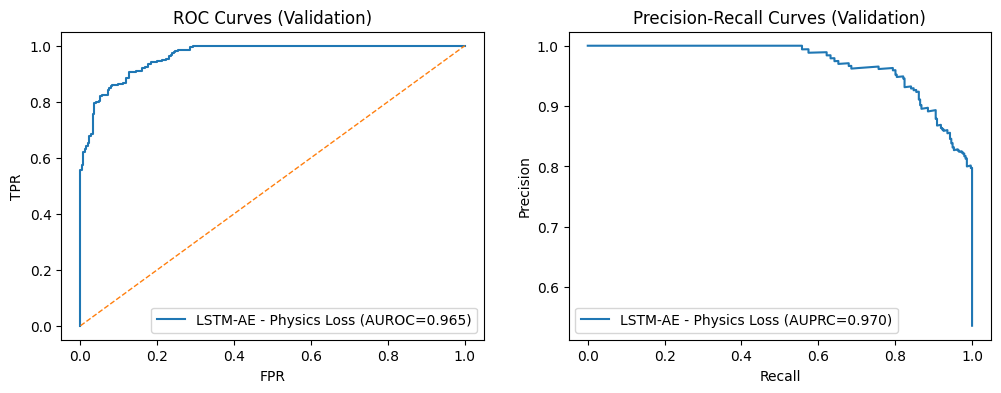

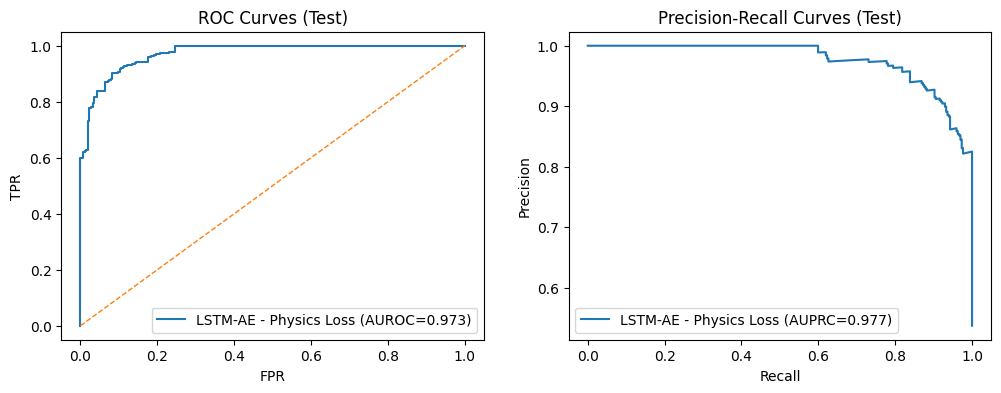

In [25]:
"""ROC AND PR CURVES ON VALIDATION & TEST"""

plot_roc_pr_curves([err_val_lstm_phys], y_val, ["LSTM-AE - Physics Loss"], "(Validation)")
plot_roc_pr_curves([err_test_lstm_phys], y_test, ["LSTM-AE - Physics Loss"], "(Test)")


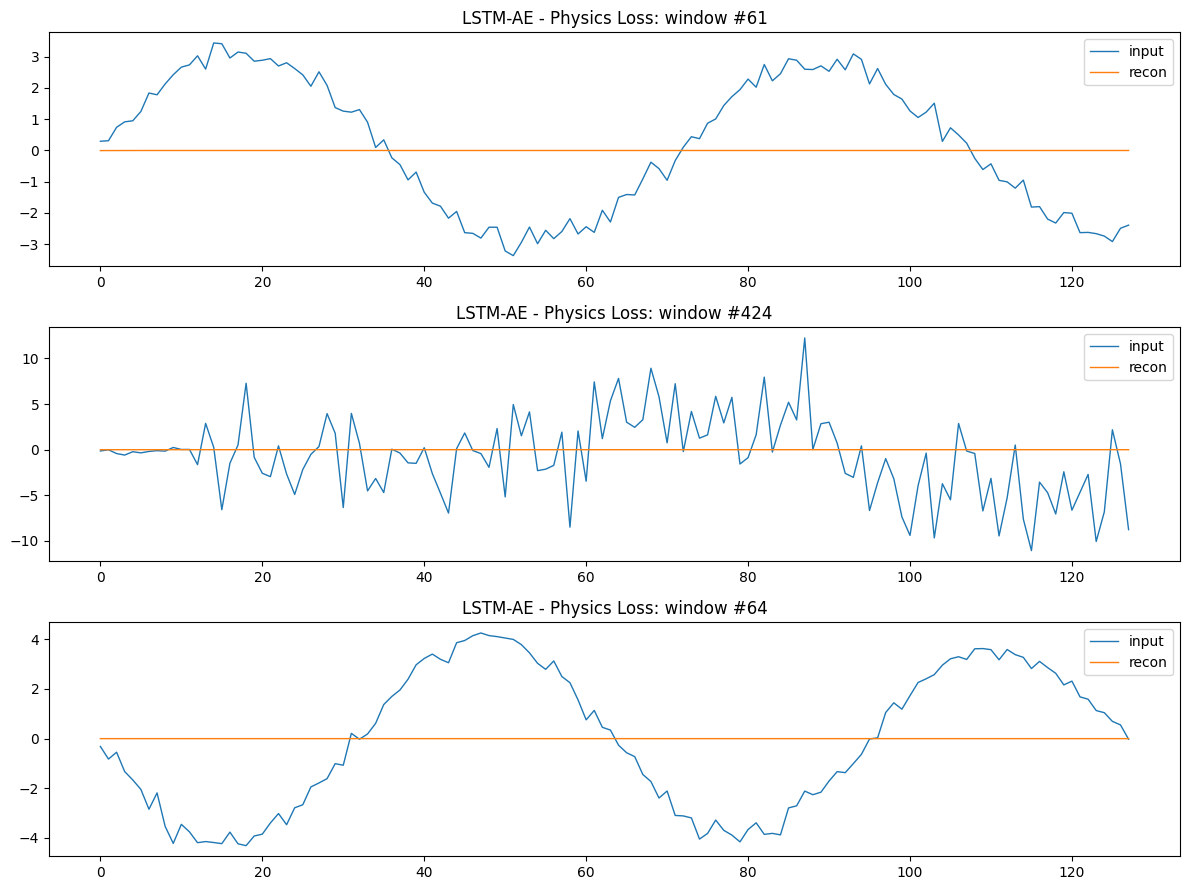

In [26]:
"""RECONSTRUCTION PLOTS"""

plot_reconstruction_examples(lstm_phys, X_test_s, n=3, title="LSTM-AE - Physics Loss")

In [27]:
"""THRESHOLD TUNING VARIANTS"""

"""
We already used F1-maximization on validation. Two common alternatives:
- Percentile-based on train normal errors (e.g., 99th percentile) for a fixed false-positive budget
- Youden's J on ROC (maximizes TPR-FPR)
We'll show how you'd compute them, then evaluate on test.
"""

# Percentile (train normals)
thr_lstm_p_phys  = threshold_percentile_on_train(lstm_phys,  X_train_s, perc=99.5)

# Youden's J (validation)
thr_lstm_y_phys  = threshold_youden(err_val_lstm_phys,  y_val)

print("\n=== Threshold strategies comparison (TEST) ===")
for name, err_t, thr_f1, thr_p, thr_y in [
    ("LSTM-AE - Physics Loss", err_test_lstm_phys,  best_lstm_phys["thr"],  thr_lstm_p_phys,  thr_lstm_y_phys),
]:
    m_f1 = eval_with(thr_f1, err_t, y_test)
    m_p  = eval_with(thr_p,  err_t, y_test)
    m_y  = eval_with(thr_y,  err_t, y_test)
    print(f"{name:8s} | F1-tuned  F1={m_f1['f1']:.3f} P={m_f1['precision']:.3f} R={m_f1['recall']:.3f} AUROC={m_f1['auroc']:.3f}")
    print(f"          | Perc(99.5) F1={m_p['f1']:.3f} P={m_p['precision']:.3f} R={m_p['recall']:.3f} AUROC={m_p['auroc']:.3f}")
    print(f"          | YoudenJ    F1={m_y['f1']:.3f} P={m_y['precision']:.3f} R={m_y['recall']:.3f} AUROC={m_y['auroc']:.3f}")


=== Threshold strategies comparison (TEST) ===
LSTM-AE - Physics Loss | F1-tuned  F1=0.894 P=0.941 R=0.852 AUROC=0.973
          | Perc(99.5) F1=0.772 P=0.974 R=0.640 AUROC=0.973
          | YoudenJ    F1=0.915 P=0.927 R=0.902 AUROC=0.973


In [28]:
"""SUMMARY"""

rows = []
rows.append(["LSTM-AE - Physics Loss", metrics_lstm_phys["auroc"],  metrics_lstm_phys["auprc"],  metrics_lstm_phys["f1"],  metrics_lstm_phys["precision"],  metrics_lstm_phys["recall"]])

df_summary = pd.DataFrame(rows, columns=["Model","AUROC","AUPRC","F1","Precision","Recall"])
print("\n=== TEST SUMMARY (F1-tuned thresholds) ===")
print(df_summary.sort_values("F1", ascending=False).reset_index(drop=True))


=== TEST SUMMARY (F1-tuned thresholds) ===
                    Model     AUROC     AUPRC        F1  Precision    Recall
0  LSTM-AE - Physics Loss  0.973064  0.976539  0.893993    0.94052  0.851852
